In [1]:
cd D:\DATA SCIENCE PROJECTS\DATASETS

D:\DATA SCIENCE PROJECTS\DATASETS


from sklearn.metrics import roc_auc_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Section 1: Business Understanding
An insurance company that has provided Health Insurance Products to its customer wants to expand its business to Vehicle Insurance. It needs to build a model to predict whether customers from the past year are interested in its new Vehicle Insurance Products to plan for marketing strategies. First, we will analyze how some variables are related to customers' interests. Then, we will build a machine learning model to classify whether a customer is interested. Customers forecasted to be interested in this product will become the target market and receive ads promoting this product.


'Previously Insured' -> whether the customer already has Vehicle Insurance from another company
'Vehicle Damage' -> wheter customer got his/her vehicle damaged in the past


# Section 2: Data Understanding

In [5]:
df=pd.read_csv("train.insurance.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217,1
1,2,Male,76,1,3,0,1-2 Year,No,33536,26,183,0
2,3,Male,47,1,28,0,> 2 Years,Yes,38294,26,27,1
3,4,Male,21,1,11,1,< 1 Year,No,28619,152,203,0
4,5,Female,29,1,41,1,< 1 Year,No,27496,152,39,0


In [7]:
# Set id as index
df.set_index('id',inplace=True)
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28,0,> 2 Years,Yes,40454,26,217,1
2,Male,76,1,3,0,1-2 Year,No,33536,26,183,0
3,Male,47,1,28,0,> 2 Years,Yes,38294,26,27,1
4,Male,21,1,11,1,< 1 Year,No,28619,152,203,0
5,Female,29,1,41,1,< 1 Year,No,27496,152,39,0


In [8]:
# Check for missing values
df.isnull().sum()

Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

There are no missing values in the Dataset

In [9]:
df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


There are several categorical variables included such as Region_Code and Policy_Sales_Channel because they are encoded as integer (although they have float dtype, we must fix it later)

In [10]:
df.corr()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
Age,1.000000,-0.079782,0.042574,-0.254682,0.067507,-0.577826,-0.001264,0.111147
Driving_License,-0.079782,1.000000,-0.001081,0.014969,-0.011906,0.043731,-0.000848,0.010155
Region_Code,0.042574,-0.001081,1.000000,-0.024659,-0.010588,-0.042420,-0.002750,0.010570
Previously_Insured,-0.254682,0.014969,-0.024659,1.000000,0.004269,0.219381,0.002537,-0.341170
Annual_Premium,0.067507,-0.011906,-0.010588,0.004269,1.000000,-0.113247,-0.000608,0.022575
Policy_Sales_Channel,-0.577826,0.043731,-0.042420,0.219381,-0.113247,1.000000,0.000002,-0.139042
Vintage,-0.001264,-0.000848,-0.002750,0.002537,-0.000608,0.000002,1.000000,-0.001050
Response,0.111147,0.010155,0.010570,-0.341170,0.022575,-0.139042,-0.001050,1.000000


In [11]:
# Check gender distribution
df['Gender'].value_counts()

Male      206089
Female    175020
Name: Gender, dtype: int64

The number of males is slightly higher than females

Text(0, 0.5, 'Total')

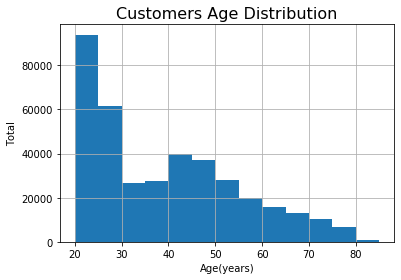

In [12]:
# Check distribution of customers age
#by using histogram
df['Age'].hist(bins=np.arange(20,90,5))#adjust bin width to 5
plt.title("Customers Age Distribution",size=16)
plt.xlabel('Age(years)')
plt.ylabel('Total')

Dominated by young (20-30 years) and middle-aged (40-50 years) customers (bimodal distribution)

In [13]:
# Check the proportion of customers interested based on driving license ownership
df.groupby('Driving_License')['Response'].mean()

Driving_License
0    0.050493
1    0.122717
Name: Response, dtype: float64

Only 0.3% of customers don't have a driving license. However, customers with no driving license tend to be not interested in vehicle insurance so, we will keep this column for prediction.

In [15]:
df['Region_Code'].nunique()#There are 53 unique values of region_code

53

In [16]:
#Group Response by Region_code,aggregated by mean
df.groupby('Region_Code')['Response'].mean().sort_values(ascending=False)

Region_Code
38    0.192004
28    0.187163
19    0.162866
4     0.158245
23    0.153061
51    0.153005
24    0.141615
7     0.131747
18    0.131574
3     0.127662
35    0.124604
39    0.123600
52    0.123596
29    0.123362
41    0.121776
40    0.118147
5     0.115715
20    0.115245
11    0.112760
45    0.109723
1     0.108135
46    0.102891
48    0.101901
31    0.100510
33    0.099294
12    0.097561
8     0.096142
43    0.092459
14    0.090209
13    0.090188
47    0.087682
0     0.086096
32    0.085755
9     0.081587
36    0.079914
37    0.079258
34    0.075721
49    0.074782
42    0.074450
27    0.074035
30    0.073825
26    0.072284
15    0.071987
2     0.071075
21    0.071027
17    0.070310
6     0.069904
16    0.066766
22    0.063407
50    0.062677
10    0.060128
25    0.042749
44    0.040842
Name: Response, dtype: float64

There are noticeable differences in customers interested proportion based on Region_Code. Because this variable is categorical, we will use dummies to encode this variable in the next section.

In [17]:
df['Previously_Insured'].value_counts()

0    206481
1    174628
Name: Previously_Insured, dtype: int64

Number of customers not having vehicle insurance is higher, presenting an opportunity for the company.

In [18]:
# Most customers vehicle age is lessthan 2
df['Vehicle_Age'].value_counts()

1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

In [19]:
df["Vehicle_Damage"].value_counts()

Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64

No significant differences between the number of customers that have experienced vehicle damage.

In [41]:
# calculate the proportion of customer interested grouped by vehicle_damage
df.groupby('Vehicle_Damage')['Response'].mean()

Vehicle_Damage
No     0.005204
Yes    0.237655
Name: Response, dtype: float64

In [42]:
#calculate the proportion of customer interested grouped by previously _Insured
df.groupby('Previously_Insured')['Response'].mean()

Previously_Insured
0    0.225454
1    0.000905
Name: Response, dtype: float64

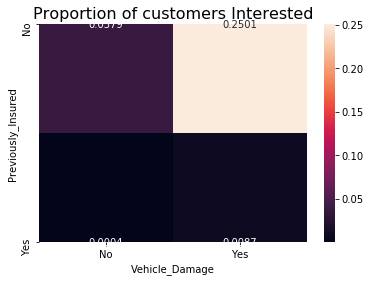

In [43]:
#Create pivot table with previously_insured and vehicle_damage as grouping variables
insured_vehicle_damage=df.pivot_table('Response',index='Previously_Insured',columns='Vehicle_Damage')
insured_vehicle_damage.rename(index={0: 'No',1:'Yes'},inplace=True)
sns.heatmap(insured_vehicle_damage,annot=True,fmt='.4f')
plt.title('Proportion of customers Interested',size=16);

From 3 cells above, customer that does not have vehicle insurance but have experienced vehicle damage are most likely to be interested in vehicle insurance product.

In [46]:
df['Policy_Sales_Channel'].nunique()

155

In [48]:
sales_channel_count=df['Policy_Sales_Channel'].value_counts()
sales_channel_count

152    134784
26      79700
124     73995
160     21779
156     10661
        ...  
144         1
123         1
143         1
149         1
84          1
Name: Policy_Sales_Channel, Length: 155, dtype: int64

In [49]:
(sales_channel_count<=100).sum()

93

There are 155 unique policy sales channels listed, with 93 channels appear less than equal 100 times. In the next section we will group these channels to 1 group called Others

Text(0.5, 0, 'Vintage(days)')

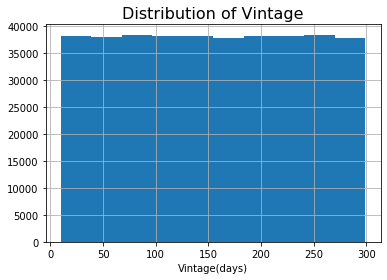

In [50]:
#check the distribution of vintage(number of days customer has been associated with the company)
df['Vintage'].hist()
plt.title('Distribution of Vintage',size=16)
plt.xlabel('Vintage(days)')

Distribution of vintage is approximately uniform

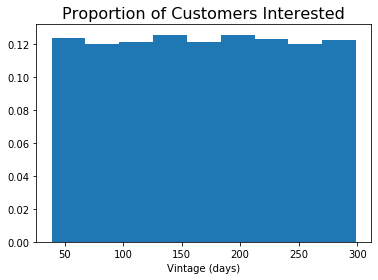

In [51]:
def plot_vintage_mean_response(df=df, bins=10):
    '''
    Plot the proportion of customer interested for every bin defined by vintage

    INPUT:
    df - pandas dataframe
    bins - number of bins

    OUTPUT:
    histograms
    '''
    xmin, xmax = df['Vintage'].min(), df['Vintage'].max()

    total_counts, bins = np.histogram(df['Vintage'],
                                      bins=bins, range=(xmin, xmax))
    yes_counts, _ = np.histogram(df['Vintage']*df['Response'],
                                 bins=bins, range=(xmin, xmax))

    plt.hist(bins[:-1], bins[1:], weights=yes_counts/total_counts)
    plt.title('Proportion of Customers Interested', size=16)
    plt.xlabel('Vintage (days)')
    return None
plot_vintage_mean_response()

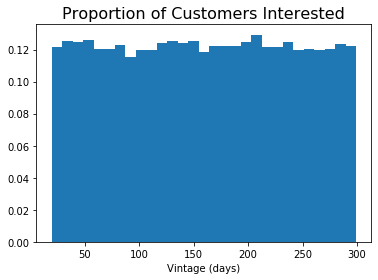

In [52]:
plot_vintage_mean_response(bins=30)

The proportion of customer interested in every bin is approximately equal. Furthermore, the absolute value of correlation between response and vintage is the lowest compared to other varibales. Hence, vintage is not a good predictor variable for response and we should consider to drop it.

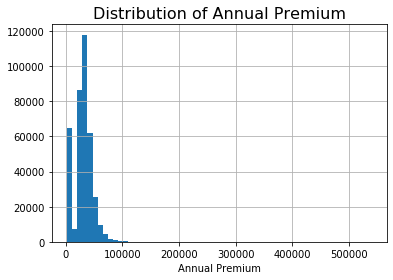

In [53]:
# The distribution of Annual Premium is right-skewed
df['Annual_Premium'].hist(bins = 60)
plt.title('Distribution of Annual Premium', size=16)
plt.xlabel('Annual Premium');

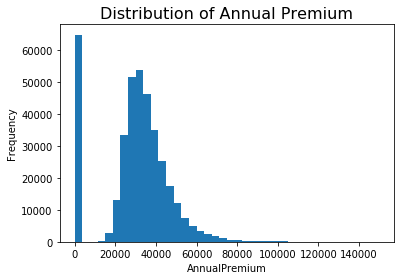

In [56]:
df['Annual_Premium'].plot(kind='hist',range=(0,150000),bins=40)
plt.title('Distribution of Annual Premium',size=16)
plt.xlabel('AnnualPremium');

It seems there are outliers, let's check it out

In [57]:
df.loc[df['Annual_Premium']<=10000,'Annual_Premium'].value_counts()

2630    64877
9816        1
7670        1
6098        1
8739        1
9792        1
Name: Annual_Premium, dtype: int64

In [58]:
# Check the data where annual premium = 2630
outliers_df = df[df['Annual_Premium'] == 2630]
outliers_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
6,Female,24,1,33,0,< 1 Year,Yes,2630,160,176,0
16,Male,37,1,6,0,1-2 Year,Yes,2630,156,147,1
31,Female,26,1,8,0,< 1 Year,No,2630,160,136,0
44,Female,38,1,35,1,1-2 Year,No,2630,152,153,0
59,Female,62,1,48,0,1-2 Year,Yes,2630,15,295,0


In [59]:
outliers_df.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,64877.000000,64877.000000,64877.000000,64877.000000,64877.0,64877.000000,64877.000000,64877.000000
mean,40.992678,0.998104,26.264177,0.361792,2630.0,113.896866,154.764323,0.131094
std,14.884384,0.043501,14.747260,0.480523,0.0,55.451527,83.634123,0.337506
min,20.000000,0.000000,0.000000,0.000000,2630.0,1.000000,10.000000,0.000000
25%,28.000000,1.000000,13.000000,0.000000,2630.0,30.000000,82.000000,0.000000
50%,40.000000,1.000000,28.000000,0.000000,2630.0,152.000000,155.000000,0.000000
75%,51.000000,1.000000,38.000000,1.000000,2630.0,156.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,2630.0,163.000000,299.000000,1.000000


There is no identifiable pattern to determine whether 2630 is an encoding for missing value, outlier, or the true value. However, we will treat it as missing value because 2630 rupees ~ $36, quite unlikely to be the true annual premium. Missing values will be imputed using column mean.

# Section 3: Data Preparation

In [60]:
# Split the dataset into predictor and response variable
X = df.drop('Response', axis=1)  # Predictor
y = df['Response']  # Response

In [61]:
# Initialize OneHot Encoder to handle categorical variables
onehot_enc = OneHotEncoder(handle_unknown='ignore')

In [66]:
def preprocess_data(df=X, onehot_enc=onehot_enc, fit=True):
    
    '''Preprocess data according to analysis from previous section and encode the categorical variables into dummies

    INPUT:
    df - dataframe to be processed

    OUTPUT:
    Numpy array containing processed data'''
    
    
    
    df=df.drop('Vintage', axis=1)  # Drop Vintage column
    
    # Change Annual Premium with value 2630 to NaN
    df.loc[df['Annual_Premium'] == 2630, 'Annual_Premium'] = np.nan
    
    # Group Policy Sales Channels that appear less than equal 100 times
    psc_count = df['Policy_Sales_Channel'].value_counts()
    low_psc_index = psc_count[psc_count <= 100].index
    df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].apply(
        lambda x: 'Others' if x in low_psc_index else str(x))
    
    df['Region_Code'] = df['Region_Code'].astype('int')  # Change dtype to int
    
    # Isolate categorical features except Driving_License and Previously_Insured
    # (already encoded as dummies)
    df_need_dummies = df[['Gender', 'Region_Code', 'Vehicle_Age',
                          'Vehicle_Damage', 'Policy_Sales_Channel']].astype('category')
    if fit:
        onehot_enc.fit(df_need_dummies)
        array_dummies = onehot_enc.transform(df_need_dummies).toarray()
        
    df_no_dummies = df[['Age', 'Driving_License',
                        'Previously_Insured', 'Annual_Premium']]
    # fill missing values (NaN) with column mean
    array_no_dummies = df_no_dummies.apply(lambda col: col.fillna(col.mean())).values

    # Concat df_no_dummies and df_dummies along the columns
    processed = np.concatenate([array_no_dummies, array_dummies], axis=1)
    
    return processed


X_processed = preprocess_data(X)
X_processed

array([[44.,  1.,  0., ...,  0.,  0.,  0.],
       [76.,  1.,  0., ...,  0.,  0.,  0.],
       [47.,  1.,  0., ...,  0.,  0.,  0.],
       ...,
       [21.,  1.,  1., ...,  0.,  0.,  0.],
       [68.,  1.,  0., ...,  0.,  0.,  0.],
       [46.,  1.,  0., ...,  0.,  0.,  0.]])

In [67]:
# Create processed data features
features = ['Age', 'Driving_License',
            'Previously_Insured', 'Annual_Premium',
            *onehot_enc.get_feature_names(['Gender', 'Region_Code', 'Vehicle_Age',
                                           'Vehicle_Damage', 'Policy_Sales_Channel'])]
features

['Age',
 'Driving_License',
 'Previously_Insured',
 'Annual_Premium',
 'Gender_Female',
 'Gender_Male',
 'Region_Code_0',
 'Region_Code_1',
 'Region_Code_2',
 'Region_Code_3',
 'Region_Code_4',
 'Region_Code_5',
 'Region_Code_6',
 'Region_Code_7',
 'Region_Code_8',
 'Region_Code_9',
 'Region_Code_10',
 'Region_Code_11',
 'Region_Code_12',
 'Region_Code_13',
 'Region_Code_14',
 'Region_Code_15',
 'Region_Code_16',
 'Region_Code_17',
 'Region_Code_18',
 'Region_Code_19',
 'Region_Code_20',
 'Region_Code_21',
 'Region_Code_22',
 'Region_Code_23',
 'Region_Code_24',
 'Region_Code_25',
 'Region_Code_26',
 'Region_Code_27',
 'Region_Code_28',
 'Region_Code_29',
 'Region_Code_30',
 'Region_Code_31',
 'Region_Code_32',
 'Region_Code_33',
 'Region_Code_34',
 'Region_Code_35',
 'Region_Code_36',
 'Region_Code_37',
 'Region_Code_38',
 'Region_Code_39',
 'Region_Code_40',
 'Region_Code_41',
 'Region_Code_42',
 'Region_Code_43',
 'Region_Code_44',
 'Region_Code_45',
 'Region_Code_46',
 'Region_Code

In [68]:
# Split the data into train data and validation data
# Use stratify argument to split the data proportionately based on response variable
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.3,
                                                  random_state=40, stratify=y)

# Section 4: Data Modelling 

We will try 2 different machine learning models to classify whether customer is interested in the new vehicle insurance. The metrics to score the model are AUC-ROC (Area under ROC curve) and the precision and recall of the model.



Logistic Regression

In [69]:
# Initiate and fit the model to the train data
log_reg = Pipeline([('scaler', StandardScaler()),  # Normalize the feature 
                    ('logistic_reg', LogisticRegression(n_jobs=-1,
                                                        class_weight='balanced'))])
# Use class weight 'balanced' because there are signifcantly more customers that are not interested
log_reg.fit(X_train, y_train)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:1544: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logistic_reg',
                 LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=-1, penalty='l2',
                                    random_state=None, solver='warn',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [70]:
# Predict the probability customer in validation data is interested
y_pred_proba = log_reg.predict_proba(X_val)[:, 1]
y_pred_proba

array([0.10654262, 0.76659375, 0.0042768 , ..., 0.77441845, 0.73612686,
       0.00624637])

In [71]:
# Calculate the predicted response and show the classification report
y_pred = log_reg.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.67      0.79    100320
           1       0.28      0.94      0.43     14013

    accuracy                           0.70    114333
   macro avg       0.63      0.80      0.61    114333
weighted avg       0.90      0.70      0.75    114333



In [72]:
# Create the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
(tn, fp, fn, tp) = conf_matrix.ravel()
log_reg_precision = tp / (tp+fp)
log_reg_recall = tp / (tp+fn)
log_reg_auc_roc = roc_auc_score(y_val, y_pred)
print('Precision: ', log_reg_precision)
print('Recall: ', log_reg_recall)
print('AUC-ROC score: ', log_reg_auc_roc)

Precision:  0.2810772592878262
Recall:  0.936202098051809
AUC-ROC score:  0.8008612164900194


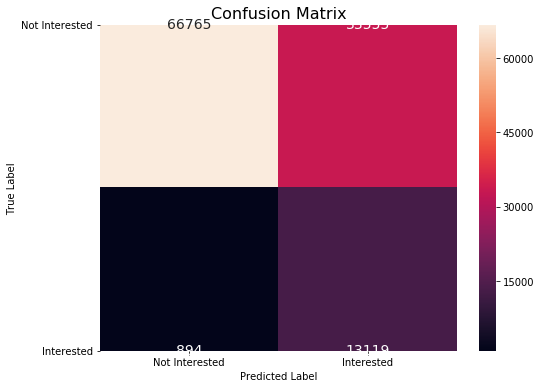

In [73]:
#Plot the confusion matrix
labels = ('Not Interested', 'Interested')

plt.figure(figsize = (8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=labels, yticklabels=labels, 
            annot_kws={'size': 14})
plt.yticks(rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix', size=16);

With 0.8 AUC-ROC score, the logistic regression model is good enough. This model is also exceptional for predicting interested customers as shown by the 94% recall (target market will be wide enough to cover most of the interested customers). Although the precision is only 28% (28% of advertised customers is interested), it is acceptable because advertising to random customers will only get 12% precision (the proportion of interested customers in the dataset is approximately 12%).

In [74]:
# Create Regression Coefficient Data Frame
reg_coef = log_reg['logistic_reg'].coef_[0]
reg_coef_df = pd.DataFrame({'abs_coef': np.abs(reg_coef),
                            'sign_coef': np.sign(reg_coef)},
                           index=features)

# Sort Data Frame based on absolute value of coefficient
# We can compare the coefficient between variables because the data have been normalized
feature_importance = reg_coef_df.sort_values('abs_coef',
                                             ascending=False).head(20)
feature_importance

,abs_coef,sign_coef
Previously_Insured,1.952624,-1.0
Vehicle_Damage_Yes,0.493019,1.0
Vehicle_Damage_No,0.493019,-1.0
Age,0.423088,-1.0
Policy_Sales_Channel_160,0.354912,-1.0
Policy_Sales_Channel_152,0.302778,-1.0
Policy_Sales_Channel_26,0.256248,1.0
Policy_Sales_Channel_124,0.172210,1.0
Vehicle_Age_< 1 Year,0.113022,-1.0
Policy_Sales_Channel_151,0.084440,-1.0


As analyzed in the previous section, Previously_Insured and Vehicle_Damage indicators are indeed the best predictor for customers' interests.

Random Forest Classifier

In [75]:
# Initiate and fit the model to the train data
rf_classifier = Pipeline([('scaler', StandardScaler()),
                          ('random_forest',
                           RandomForestClassifier(n_estimators=300,
                                                  n_jobs=-1,
                                                  class_weight='balanced'))])
rf_classifier.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('random_forest',
                 RandomForestClassifier(bootstrap=True, class_weight='balanced',
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=300, n_jobs=-1,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

In [76]:
# Predict the probability customer in validation data is interested
y_pred_proba = rf_classifier.predict_proba(X_val)[:, 1]
y_pred_proba

array([0.        , 0.61333333, 0.        , ..., 0.33333333, 0.03584958,
       0.        ])

In [77]:
# Calculate the predicted response and show the classification report
y_pred = rf_classifier.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.92      0.91    100320
           1       0.32      0.26      0.29     14013

    accuracy                           0.84    114333
   macro avg       0.61      0.59      0.60    114333
weighted avg       0.83      0.84      0.83    114333



In [78]:
# Create the confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)
(tn, fp, fn, tp) = conf_matrix.ravel()
rf_precision = tp / (tp+fp)
rf_recall = tp / (tp+fn)
rf_auc_roc = roc_auc_score(y_val, y_pred)
print('Precision: ', rf_precision)
print('Recall: ', rf_recall)
print('AUC-ROC score: ', rf_auc_roc)

Precision:  0.3195939982347749
Recall:  0.2584029115821023
AUC-ROC score:  0.5907794063492648


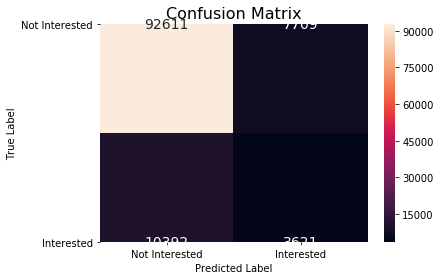

In [79]:
#Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=labels, yticklabels=labels,
            annot_kws={'size': 14})
plt.yticks(rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix', size=16);

Even though the precision in this model is higher than the logistic regression model, the recall and AUC-ROC score is considerably lower, meaning that the target market is not large enough, as shown by the confusion matrix. Only 9500 customers will receive ads compared to around 38000 by using logistic regression. Therefore, this model is not good enough to predict whether a customer is interested

Section 5: Evaluate the Results


In [84]:
feature_importance.head(5)

,abs_coef,sign_coef
Previously_Insured,1.952624,-1.0
Vehicle_Damage_Yes,0.493019,1.0
Vehicle_Damage_No,0.493019,-1.0
Age,0.423088,-1.0
Policy_Sales_Channel_160,0.354912,-1.0


In [86]:
# Unpivot table to plot as bar chart
insured_damage_df = pd.melt(insured_vehicle_damage.reset_index(),
                            id_vars='Previously_Insured',
                            value_vars=['Yes', 'No'],
                            value_name='Prop_Response')
insured_damage_df

,Previously_Insured,Vehicle_Damage,Prop_Response
0,No,Yes,0.250105
1,Yes,Yes,0.008668
2,No,No,0.037932
3,Yes,No,0.000437


In [ ]:
# Show metrics of the best model
print('Precision: ', log_reg_precision)
print('Recall: ', log_reg_recall)
print('AUC-ROC score: ', log_reg_auc_roc)

The best model is Logistic Regression